# Diagnosing Heart Disease through Serum Cholesterol Levels and Resting Blood Pressure

DSCI 100 Group 30 Project Proposal

Group Members: Ziming Zhang, Alexander Tracey, Albert Guo, Kevin Butchart

## Introduction

Currently, medical equipment like X-ray and electrocardiogram machines are expensive, unavailable, or unfeasible, the chances of going undiagnosed for heart-related issues are massive. This project aims to answer the question of **whether cases of heart disease can be accurately classified using measurements of resting blood pressure and serum cholesterol**. These measurements were chosen due to their relatively cheaper cost to produce when compared to other measures such as electrocardiograph results. The dataset used was donated by researchers at the Department of Medicine, Veterans Administration Medical Center, Long Beach, California in 1988. It compiled data of various patient test groups from America, Hungary and Switzerland, and proposed an algorithm using the data that could be used to identify heart disease.

## Preliminary exploratory data analysis

In [1]:
#install.packages("gridExtra")
library(tidyverse)
library(tidymodels)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
#We first download the data from Kaggle (https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset) to the notebook folder, 
#and read the dataset using relative path. 

data <- read_csv("heart.csv")

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1


In [4]:
#Wrangling
data <- data |>
    mutate(target = as_factor(target),
          sex = as_factor(sex),
          age = as.integer(age),
          target = fct_recode(target, "disease" = "1", "no_disease" = "0"),
          sex = fct_recode(sex, "female" = "0", "male" = "1")) |>
    select(age, sex, trestbps, chol, target)

In [5]:
head(data)

age,sex,trestbps,chol,target
<int>,<fct>,<dbl>,<dbl>,<fct>
52,male,125,212,no_disease
53,male,140,203,no_disease
70,male,145,174,no_disease
61,male,148,203,no_disease
62,female,138,294,no_disease
58,female,100,248,disease


In [6]:
#Split into training and testing datasets
set.seed(2023)
heart_split <- initial_split(data, prop = 0.75, strata = target)  
training_set <- training(heart_split)   
testing_set <- testing(heart_split)

In [7]:
#Check if there are missing values or not
identical(training_set, na.omit(training_set))

[1] TRUE

Since the datasets are the same before and after dropping the missing (NA) values, we can say that there are no missing values in the training set. Then, we create some summarize tables and plots to demonstrate our dataset:

In [8]:
#The mean value for each potantial predictors
mean_predictors <- training_set |>
    select(age, trestbps, chol) |>
    map_df(mean)
mean_predictors

age,trestbps,chol
<dbl>,<dbl>,<dbl>
54.39974,131.5755,245.5677


In [9]:
#Number of diseases
disease <- training_set |>
    group_by(target) |>
    summarize(count = n())
disease

target,count
<fct>,<int>
no_disease,374
disease,394


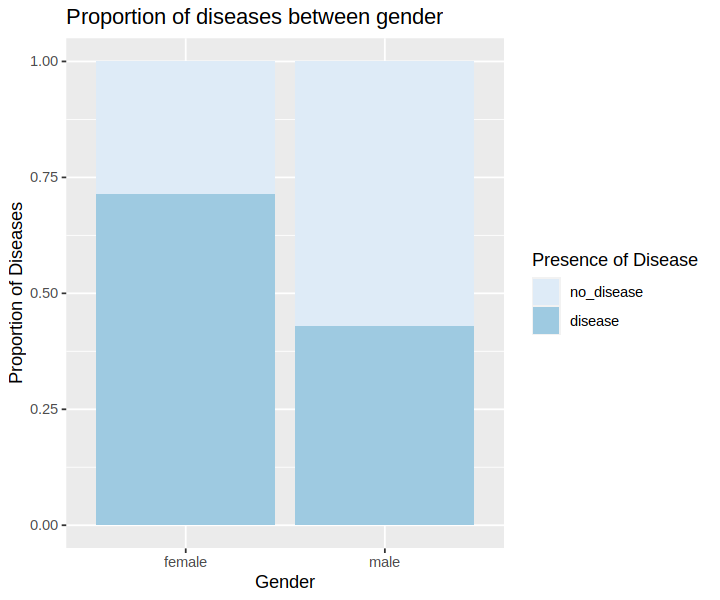

In [10]:
#Heart disease among males and females
options(repr.plot.width = 6, repr.plot.height = 5)
heart_plot_sex <- training_set |>
    ggplot(aes(x=sex, fill=target)) + 
    geom_bar(position = 'fill') + 
    labs(x = "Gender",y = "Proportion of Diseases",fill = "Presence of Disease", title = "Proportion of diseases between gender") +
    scale_fill_brewer()
heart_plot_sex

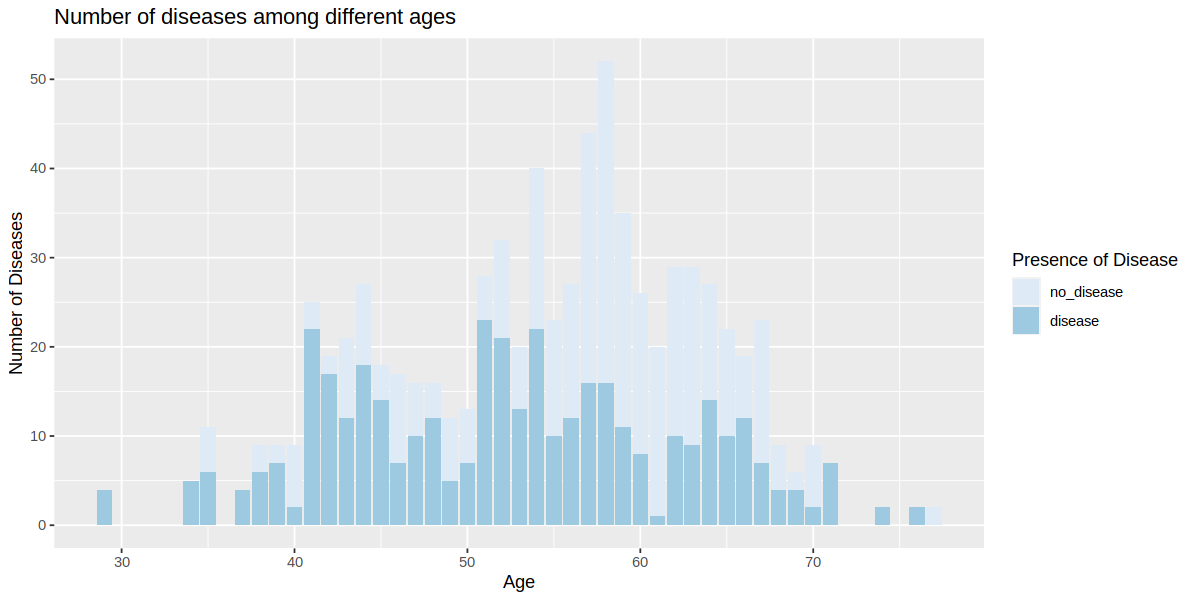

In [11]:
options(repr.plot.width = 10, repr.plot.height = 5)
heart_plot_age <- training_set |>
    ggplot(aes(x=age, fill=target)) + 
    geom_bar() + 
    labs(x = "Age",y = "Number of Diseases",fill = "Presence of Disease", title = "Number of diseases among different ages") +
    scale_fill_brewer()
heart_plot_age

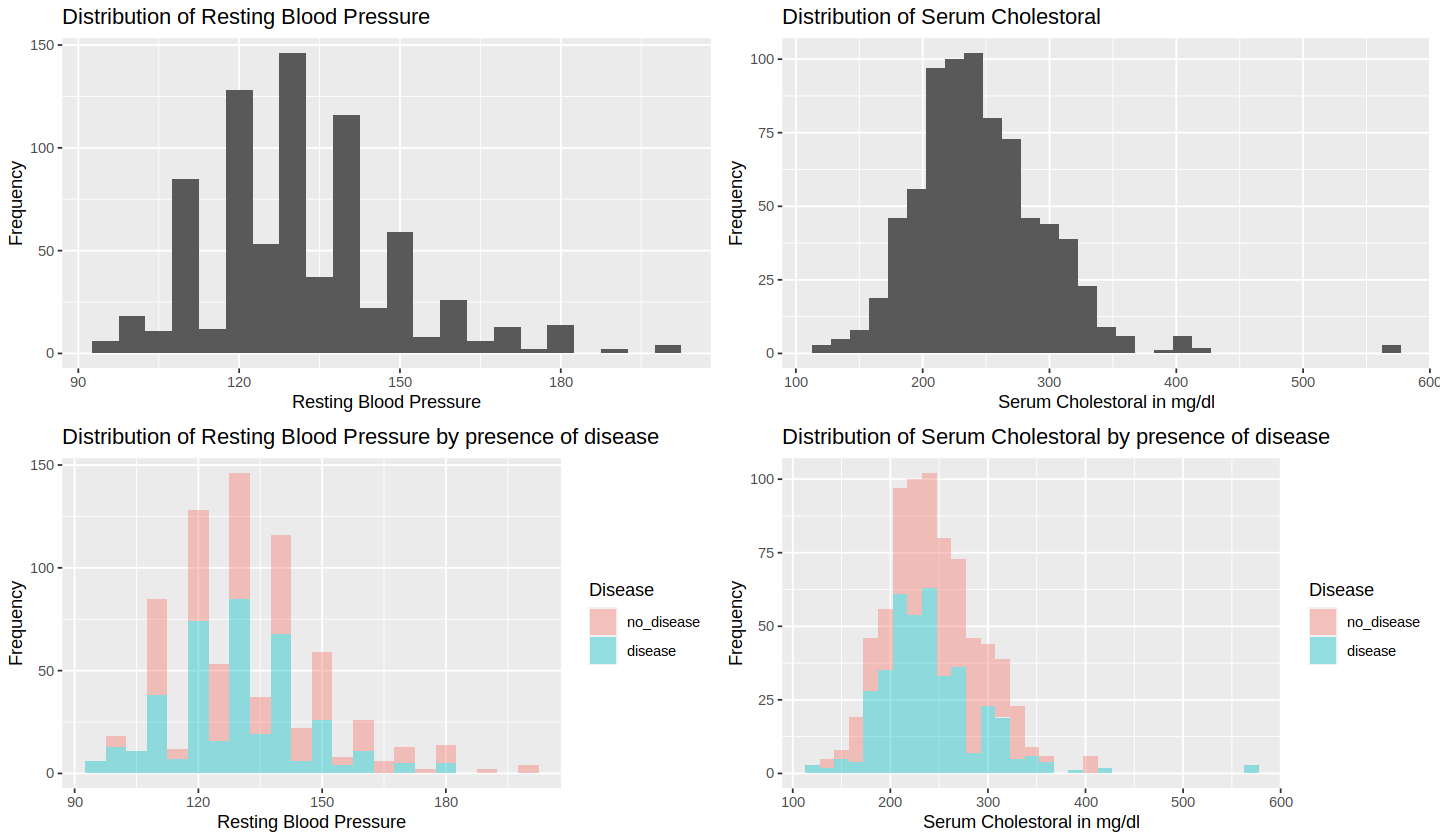

In [12]:
#Distribution of predictors
options(repr.plot.width = 12, repr.plot.height = 7)
rbp_distribution_plot <- training_set |> 
    ggplot(aes(x = trestbps)) +
    geom_histogram(binwidth = 5) +
    labs(title = "Distribution of Resting Blood Pressure", x = "Resting Blood Pressure", y = "Frequency") 

chol_distribution_plot <- training_set |> 
    ggplot(aes(x = chol)) +
    geom_histogram(binwidth = 15) +
    labs(title = "Distribution of Serum Cholestoral", x = "Serum Cholestoral in mg/dl", y = "Frequency")

rbp_distribution_plot2 <- training_set |>
    ggplot(aes(x=trestbps, fill = target)) +
    geom_histogram(binwidth = 5,alpha = 0.4) +
    labs(title = "Distribution of Resting Blood Pressure by presence of disease", 
         x = "Resting Blood Pressure", y = "Frequency", fill = "Disease")

chol_distribution_plot2 <- training_set |>
    ggplot(aes(x=chol, fill = target)) +
    geom_histogram(binwidth = 15,alpha = 0.4) +
    labs(title = "Distribution of Serum Cholestoral by presence of disease", 
         x = "Serum Cholestoral in mg/dl", y = "Frequency", fill = "Disease")

grid.arrange(rbp_distribution_plot, chol_distribution_plot, rbp_distribution_plot2, chol_distribution_plot2, nrow = 2)

## Methods

This project focuses on age, sex, blood pressure, cholesterol levels, and target diagnosis, so other attributes will not be of use for this project.  Age and sex will be considered after the initial analysis.  Target diagnosis is a categorical variable, so we will be using K-nearest neighbors classification to create our model. 

To determine whether or not blood pressure and cholesterol levels are good predictors, we will create 3 models: one using only blood pressure, one using only cholesterol levels, and one using both.

For each of our models we will vfold our training data into 5 parts and tune them using cross-validation.  Once we have determined the optimal K value for each, we will test the models on the testing data.  Through this, we can determine which model was the most effective.

To visualize our models’ respective effectiveness, we will plot the accuracy of each model at every K-value we tested.

## Expected outcomes and significance

We expect to find that higher serum cholesterol and resting blood pressure correlates with a higher amount of heart disease, meaning these two measures could be used to identify cases of heart disease. High serum cholesterol increases the risk of fatty deposits in arteries and blood vessels, which can restrict blood flow and cause blood clots Additionally, high blood pressure can cause damage to blood vessels and arteries by making them less elastic. This causes less blood and oxygen flow, which increases the risk of heart disease and chest pain. For these reasons we expect a higher serum cholesterol and resting blood pressure to both have strong positive correlation with heart disease and can be used to identify heart disease.

Heart disease is the leading cause of death in the world so it affects everyone. Through this research, heart disease can be more easily and cheaply diagnosed through data instead of expensive tests. Using these metrics, heart disease can also be better prevented by finding and solving causes of high levels of these two metrics. Future questions could include how other factors work together and affect each other in diagnosing heart disease. One example could include how serum cholesterol levels are affected by weekly physical activity, or how height, weight, and BMI can be used in tandem to identify heart disease.
